In [1]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<h1 id="dataset" style="color:#01499b; background:white; border:0.5px dotted #01499b;"> 
    <center>Dataset
        <a class="anchor-link" href="#dataset" target="_self">¶</a>
    </center>
</h1>

# Feature engineering

## Load data

In [2]:
path = '../input/alzheimer-features/alzheimer.csv'
df = pd.read_csv(path)

df['MMSE'] = df['MMSE'].fillna(0)
df['SES'] = df['SES'].fillna(0)

# pick only demented or nondemented
df = df[df['Group'].isin(['Demented','Nondemented'])]

df.head()

,Group,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,Nondemented,M,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,Nondemented,M,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,Demented,M,75,12,0.0,23.0,0.5,1678,0.736,1.046
3,Demented,M,76,12,0.0,28.0,0.5,1738,0.713,1.010
4,Demented,M,80,12,0.0,22.0,0.5,1698,0.701,1.034


## Categorical encoding

In [3]:
group_to_idx = {'Nondemented': 0, 'Demented': 1}
idx_to_group = {group_to_idx[k]:k for k in group_to_idx.keys()}

sex_to_idx = {'M': 0, 'F': 1}
idx_to_sex = {sex_to_idx[k]:k for k in sex_to_idx.keys()}

df.replace(group_to_idx, inplace=True)
df.replace(sex_to_idx, inplace=True)
df = df.reset_index()

## Describe features

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
index,336.0,185.556548,107.897864,0.000,95.75000,181.500,281.250,372.000
Group,336.0,0.434524,0.496434,0.000,0.00000,0.000,1.000,1.000
M/F,336.0,0.562500,0.496818,0.000,0.00000,1.000,1.000,1.000
Age,336.0,76.711310,7.614793,60.000,71.00000,76.000,82.000,98.000
EDUC,336.0,14.502976,2.900333,6.000,12.00000,14.000,16.000,23.000
SES,336.0,2.401786,1.239594,0.000,1.00000,2.000,3.000,5.000
MMSE,336.0,27.032738,4.346431,0.000,26.00000,29.000,30.000,30.000
CDR,336.0,0.294643,0.385678,0.000,0.00000,0.000,0.500,2.000
eTIV,336.0,1491.306548,179.940267,1106.000,1357.00000,1475.000,1599.750,2004.000
nWBV,336.0,0.730211,0.037313,0.644,0.70075,0.731,0.756,0.837


## Standard Scaler

In [5]:
scaler = StandardScaler()
df[['Age', 'EDUC', 'SES', 'MMSE', 'eTIV']] = scaler.fit_transform(df[['Age', 'EDUC', 'SES', 'MMSE', 'eTIV']])

## Correlation matrix

<AxesSubplot:>

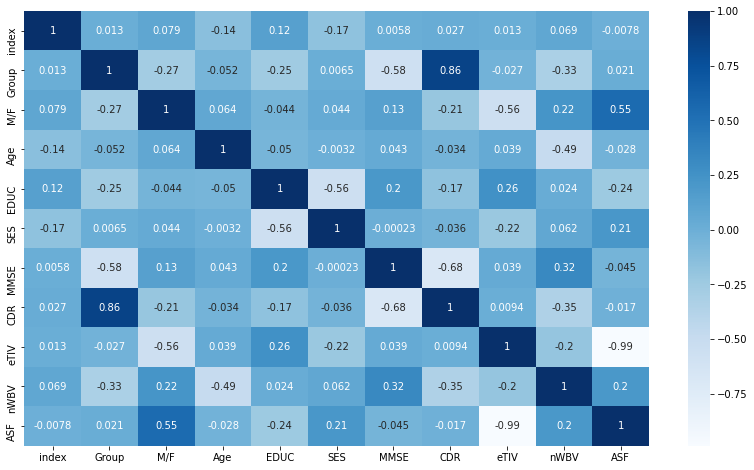

In [6]:
plt.figure(figsize=(14,8))

corr = df.corr()

sns.heatmap(corr, 
        cmap="Blues", annot=True,
        xticklabels=corr.columns,
        yticklabels=corr.columns)

## PCA dimension reduction

In [7]:
pca = PCA(n_components=2)
X_tr = pca.fit_transform(df[['CDR','SES', 'ASF']])

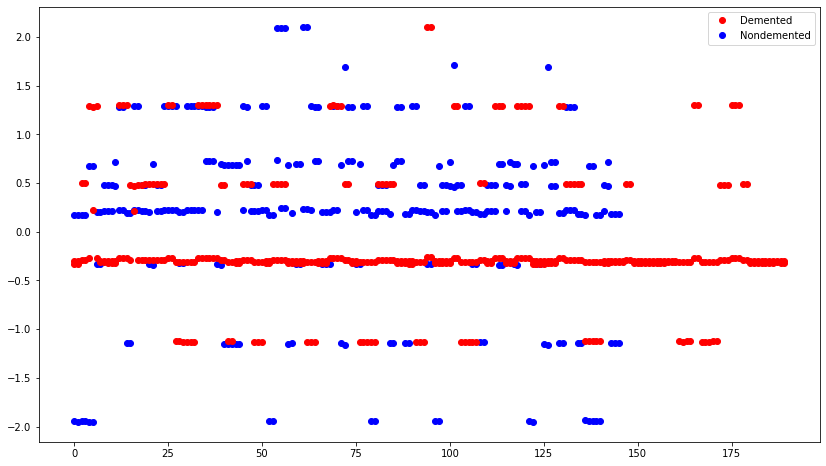

In [8]:
group_one = df[df['Group'] == 1].index
group_zero = df[df['Group'] == 0].index

plt.figure(figsize=(14,8))
blue, _ = plt.plot(X_tr[group_one], 'bo', label='Nondemented')
red, _ = plt.plot(X_tr[group_zero], 'ro', label='Demented')
plt.legend(handles=[red, blue])
plt.show()

In [9]:
# one hot encoding
y = to_categorical(df['Group'].values)

# train/test data split
X_train, X_test, y_train, y_test = train_test_split(
                                    X_tr, y, test_size=0.5, random_state=42)

<h1 id="base" style="color:#01499b; background:white; border:0.5px dotted #01499b;"> 
    <center>Auto-Encoder
        <a class="anchor-link" href="#base" target="_self">¶</a>
    </center>
</h1>

In [10]:
def base_autoencoder(X_train, X_test):
    model = Sequential()
    model.add(Dense(10, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(2, activation='linear'))
    
    model.compile(loss='mse', optimizer=SGD(lr=0.01, momentum=0.9))
    model.fit(X_train, X_test, epochs=100, verbose=0)
    
    train_mse = model.evaluate(X_train, X_train, verbose=0)
    test_mse = model.evaluate(X_test, X_test, verbose=0)
    print('> reconstruction error train=%.3f, test=%.3f' % (train_mse, test_mse))
    return model

<h1 id="evaluate" style="color:#01499b; background:white; border:0.5px dotted #01499b;"> 
    <center>Evaluate
        <a class="anchor-link" href="#evaluate" target="_self">¶</a>
    </center>
</h1>

In [11]:
def evaluate(model, X_train, y_train, X_test, y_test):
    # remember the current output layer
    output_layer = model.layers[-1]
    
    # remove the output layer
    model.pop()
    # mark all remaining layers as non-trainable
    for layer in model.layers:
        layer.trainable = False
        
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.9), metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=100, verbose=0)
    
    # evaluate model
    _, train_acc = model.evaluate(X_train, y_train, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    
    # put the model back together
    model.pop()
    model.add(output_layer)
    model.compile(loss='mse', optimizer=SGD(lr=0.01, momentum=0.9))
    return train_acc, test_acc

In [12]:
scores = dict()

# create base encoder
model = base_autoencoder(X_train, X_test)

# evaluate
train_acc, test_acc = evaluate(model, X_train, y_train, X_test, y_test)
print('> lassifier accuracy layers=%d, train=%.3f, test=%.3f' % (len(model.layers), train_acc, test_acc))
scores[len(model.layers)] = (train_acc, test_acc)

> reconstruction error train=0.733, test=0.592
> lassifier accuracy layers=2, train=0.994, test=0.994


<h1 id="layer" style="color:#01499b; background:white; border:0.5px dotted #01499b;"> 
    <center>Add-Layer
        <a class="anchor-link" href="#layer" target="_self">¶</a>
    </center>
</h1>

In [13]:
def add_layer(model, X_train, X_test):
    # remember the current output layer
    output_layer = model.layers[-1]
    
    # remove the output layer
    model.pop()
    # mark all remaining layers as non-trainable
    for layer in model.layers:
        layer.trainable = False
        
    # add a new hidden layer
    model.add(Dense(10, activation='relu', kernel_initializer='he_uniform'))
    model.add(output_layer)
    
    # fit model
    model.fit(X_train, X_test, epochs=100, verbose=0)
    
    # evaluate reconstruction loss
    train_mse = model.evaluate(X_train, X_train, verbose=0)
    test_mse = model.evaluate(X_test, X_test, verbose=0)
    
    print('> reconstruction error train=%.3f, test=%.3f' % (train_mse, test_mse))

In [14]:
n_layers = 5

for _ in range(n_layers):
    # add layer
    add_layer(model, X_train, X_test)
    # evaluate model
    train_acc, test_acc = evaluate(model, X_train, y_train, X_test, y_test)
    print('> classifier accuracy layers=%d, train=%.3f, test=%.3f' % (len(model.layers), train_acc, test_acc))
    scores[len(model.layers)] = (train_acc, test_acc)

> reconstruction error train=0.763, test=0.610
> classifier accuracy layers=3, train=0.923, test=0.881
> reconstruction error train=0.756, test=0.608
> classifier accuracy layers=4, train=0.893, test=0.958
> reconstruction error train=0.753, test=0.599
> classifier accuracy layers=5, train=0.756, test=0.827
> reconstruction error train=0.758, test=0.605
> classifier accuracy layers=6, train=0.845, test=0.929
> reconstruction error train=0.715, test=0.573
> classifier accuracy layers=7, train=0.571, test=0.560


<h1 id="evaluate" style="color:#01499b; background:white; border:0.5px dotted #01499b;"> 
    <center>Evaluate
        <a class="anchor-link" href="#evaluate" target="_self">¶</a>
    </center>
</h1>

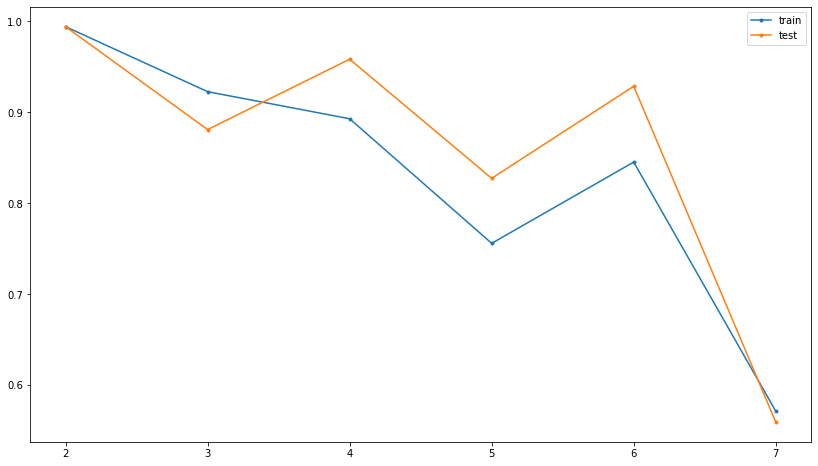

In [15]:
keys = list(scores.keys())
plt.figure(figsize=(14,8))
plt.plot(keys, [scores[k][0] for k in keys], label='train', marker='.')
plt.plot(keys, [scores[k][1] for k in keys], label='test', marker='.')
plt.legend()
plt.show()